# Introduction
This is an exploratory data analysis project using ridership data from Divvy, a bike sharing system, in Chicago, US. The data can be obtained from the [link](https://divvy-tripdata.s3.amazonaws.com/index.html) here. The data from Divvy contains the trip details, like the bike stations and trip durations etc. Additional [geocode](https://console.cloud.google.com/apis/library/geocoding-backend.googleapis.com) and [weather](https://console.cloud.google.com/marketplace/product/noaa-public/gsod) data from the Google Cloud Platform are included in. GCP was chosen as other geocoding and weather APIs on the net are subscription-based while GCP offers a 3-months free trial. 

The main hurdle for this analysis is the retrieval of accurate geocodes based on the bike station names. As the bike station names and the actual locations at which the stations are located are different, and GCP geocoding API returns slightly different outputs on runs from different days, the geocodes in this analysis are not 100% accurate. It would be best if Divvy has an additional station dataset that comes with the latitude and longitude data of the bike stations.

The main objective of this analysis mainly lies with retrieving data from different sources (Divvy and Google Cloud) and combining the data for meaningful descriptive analysis of the whole dataset. Main questions would be how riders' behaviours change over different seasons, which are the most popular stations and trips and the demographics, trip duration and distance distributions of the riders. 

# Section 1: Load and clean data

In [27]:
# Libraries
import pandas as pd
import numpy as np

import os
import math

import json
import httplib2 as http 
from urllib.parse import urlparse

from datetime import datetime

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go 

In [2]:
# Load dataset
dir_path = "../dataset/divvy/"

# Create empty data frame to collect all data
df = pd.DataFrame()

for i in os.listdir(dir_path):
    
    file_path = dir_path + i 
    if "Divvy" not in file_path:
        continue
    
    temp = pd.read_csv(file_path)
    
    # Q2 column names are not consistent with the other 3 quarters.
    temp.columns = ['trip_id', 'start_time', 'end_time', 
                    'bikeid', 'tripduration',
                    'from_station_id', 'from_station_name', 
                    'to_station_id', 'to_station_name', 
                    'usertype', 'gender', 'birthyear']
    
    df = pd.concat([df, temp])

In [3]:
# Preprocessing
df["birthyear"] = df["birthyear"].astype(int, errors="ignore")
df = df[df["birthyear"] >= 1919]            # remove people age > 100

In [4]:
# Look for same stations with different station names
def find_dup_stat():
    
    # Unique station ids (some stations have different names for the same id)
    station_ids = np.sort(df["from_station_id"].unique())

    station_dict = dict()

    for id in station_ids:
        
        stations_with_id = df[df["from_station_id"] == id]
        
        unique_stat_name = stations_with_id["from_station_name"].unique()
        
        if len(unique_stat_name) > 1:
            station_dict[id] = unique_stat_name
            
    return station_dict

In [ ]:
find_dup_stat()

#### Quick Note
* Assuming temporary stations to replace renovated stations are not far away, distance between the two stations are negligible.
    * Remove ` (*)` and ` (Temp)`. 

In [6]:
# Replace special characters and temp station names
df["from_station_name"] = df["from_station_name"].replace({" \(\*\)": "", " \(Temp\)": ""}, regex=True)
df["to_station_name"] = df["to_station_name"].replace({" \(\*\)": "", " \(Temp\)": ""}, regex=True)

#### Quick Note
* Cannot find "Franklin St & Quincy St" station
* Cannot find "Racine Ave (May St) & Fulton St" station
* Cannot find "Loomis St & Taylor St" station
* To replace these stations with the one closeby. 

In [7]:
# Replace names of three stations
station_replace = {"Loomis St & Taylor St": "Throop (Loomis) St & Taylor St",
                   "Racine Ave \(May St\) & Fulton St": "Elizabeth (May) St & Fulton St",
                   "Franklin St & Quincy St": "Franklin St & Adams St"}

df["from_station_name"] = df["from_station_name"].replace(station_replace, regex=True)
df["to_station_name"] = df["to_station_name"].replace(station_replace, regex=True)

In [8]:
find_dup_stat()

{}

In [ ]:
# Search for trips that aren't taken by customers or subscribers.
from_station_name_count = df["from_station_name"].value_counts()
to_station_name_count = df["from_station_name"].value_counts()

from_station_name_count 

#### Quick Note
* There are bike trips that look like servicing/repair jobs rather than trips taken by customers or subscribers. These are marked by unusual bike station names.
* Names that are not bike stations so they will be removed from the analysis
    * `DIVVY CASSETTE REPAIR MOBILE STATION`
    * `LBS - BBB La Magie`
    * `TS ~ DIVVY PARTS TESTING`
    * `Special Events`
    * `HUBBARD ST BIKE CHECKING (LBS-WH-TEST)`
    * `DIVVY Map Frame B/C Station`

In [10]:
# Remove trip records from analysis
remove_records = ["DIVVY CASSETTE REPAIR MOBILE STATION", 
                  "LBS - BBB La Magie",
                  "TS ~ DIVVY PARTS TESTING", 
                  "Special Events", 
                  "HUBBARD ST BIKE CHECKING (LBS-WH-TEST)", 
                  "DIVVY Map Frame B/C Station"]

df = df[~df["from_station_name"].isin(remove_records)]
df = df[~df["to_station_name"].isin(remove_records)]

# Section 2: Retrieve geocoding data from Google Cloud Platform

## Google Cloud Geocoding
* To obtain the geocode coordinates from Google Cloud Geocoding API (free trial).
* Other geocoding APIs on the net requires subscription fees.
* Google Cloud geocoding also requires subscription fee, but it has a free trial version.
* Geocoding not 100% accurate. --> First pass through Geocoding API, then second pass Places API

In [11]:
# Replacing ampersand with "and" as ampersand is read as a parameter separator in the url
station_names = pd.Series(df["to_station_name"].unique())

station_names_f = station_names.replace({"&": "and", " ": "%20"}, regex=True)

## Geocoding inaccuracies issue
* The inaccurate geocode API returns coordinates of Chicago city center instead of bike station.
* The inaccuracy comes from geocoding the bike station name instead of the actual street name.
* Bike station names don't reflect the actual street name. 
    * For example, bike station name `Canal St & Jackson Blvd` is located on `South Canal St & West Jackson Blvd`.
    * But the geocoding API may not be able to find the correct street when searching for `Canal St & Jackson Blvd`, so it returns an `APPROXIMATE` location, which points to Chicago city center, which isn't correct.
* Both geocode and place API return similar results, with multiple city center entries.
* Need to supply NSEW directionality to make the geocoding more accurate, which essentially is the street name instead of the station name.
* But NSEW not provided in the dataset, and cannot be easily inferred. 

## Approach
1. For coordinates with `GEOMETRIC_CENTER`, leave them out as station name and station location are mostly the same. 
2. Compile list of bike stations with `APPROXIMATE` as location accuracy.
3. Pass it through the Places API after Geocoding API.
4. Manually sort out the remaining stations with duplicated or missing coordinates.

In [12]:
# First pass: Geocode API obtain coordinates loop
with open("./geocode_apikey.txt") as k:
    geocode_key = k.readlines()[0]
    
headers = {"AccountKey": geocode_key,
           "accept": "application/json"}

uri = "https://maps.googleapis.com/maps/api/geocode/json?address="

lat_lng = []
results_size = []
location_types = []

for station in station_names_f:
    
    url = uri + "chicago%20" +  station + "&key=" + geocode_key
    
    method = "GET"
    body = ""
    h = http.Http()
    
    target = urlparse(url)
    
    response, content = h.request(
        target.geturl(),
        method,
        body,
        headers
    )
    
    if json.loads(content)["status"] == "OK":
        
        # Appending length of json content
        results_size.append(len(json.loads(content)["results"][0]))
        
        # Appending (lat, lng) into list
        lat = json.loads(content)["results"][0]["geometry"]["location"]["lat"]
        lng = json.loads(content)["results"][0]["geometry"]["location"]["lng"]
        
        lat_lng.append((lat, lng))
        
        # Appending approx or geometric center etc into list
        location_type = json.loads(content)["results"][0]["geometry"]["location_type"]
        location_types.append(location_type)
    
    else:
    
        results_size.append(np.nan)
        lat_lng.append(np.nan)
        location_types.append("Missing")
        
geocode_df = pd.DataFrame({"station_names": station_names,
                           "station_names_f": station_names_f,
                           "results_size": results_size,
                           "lat_lng": lat_lng,
                           "location_type": location_types})

In [13]:
# Filter out geocodes that are inaccurate based on location type
approx_df = geocode_df[geocode_df["location_type"].isin(["APPROXIMATE", "Missing"])]

In [14]:
# Second pass: Map API Place Search
with open("./gmap_apikey.txt") as k:
    gmap_key = k.readlines()[0]
    
headers = {"AccountKey": gmap_key,
           "accept": "application/json"}

uri = "https://maps.googleapis.com/maps/api/place/textsearch/json?query="

lat_lng = []
results_size = []
location_types = []
st_names = []

for station in approx_df["station_names_f"]:
    
    url = uri + "chicago%20" +  station + "&key=" + gmap_key
    
    method = "GET"
    body = ""
    h = http.Http()
    
    target = urlparse(url)
    
    response, content = h.request(
        target.geturl(),
        method,
        body,
        headers
    )
    
    if json.loads(content)["status"] == "OK":
        
        # Appending length of json content
        results_size.append(len(json.loads(content)["results"][0]))
        
        # Appending (lat, lng) into list
        lat = json.loads(content)["results"][0]["geometry"]["location"]["lat"]
        lng = json.loads(content)["results"][0]["geometry"]["location"]["lng"]
        
        lat_lng.append((lat, lng))
        
        # Appending approx or geometric center etc into list
        location_type = json.loads(content)["results"][0]["types"]
        location_types.append(location_type)
        
        # Appending actual name of street
        st_names.append(json.loads(content)["results"][0]["name"])
    
    else:
    
        results_size.append(np.nan)
        lat_lng.append(np.nan)
        location_types.append("Missing")
        st_names.append("Missing")
        
gmap_df = pd.DataFrame({"station_names": approx_df["station_names"],
                        "station_names_f": approx_df["station_names_f"],
                        "results_size": results_size,
                        "lat_lng": lat_lng,
                        "location_type": location_types,
                        "st_names": st_names})

In [15]:
# Filter out the geocode coordinates which are not APPROXIMATE & Missing
geocode_df2 = geocode_df[~geocode_df["location_type"].isin(["APPROXIMATE", "Missing"])]

# Remove st_names variable from gmap_df
gmap_df = gmap_df.drop("st_names", axis=1)

# Row bind both data frames together
geocode_df3 = pd.concat([geocode_df2, gmap_df], axis=0).reset_index().drop("index", axis=1)

In [17]:
geocode_df3.head()

,station_names,station_names_f,results_size,lat_lng,location_type
0,Kimball Ave & Belmont Ave,Kimball%20Ave%20and%20Belmont%20Ave,5.0,"(41.9392819, -87.7124876)",GEOMETRIC_CENTER
1,Pine Grove Ave & Waveland Ave,Pine%20Grove%20Ave%20and%20Waveland%20Ave,5.0,"(41.9497223, -87.64665079999999)",GEOMETRIC_CENTER
2,Maplewood Ave & Peterson Ave,Maplewood%20Ave%20and%20Peterson%20Ave,5.0,"(41.9904253, -87.6933049)",GEOMETRIC_CENTER
3,Broadway & Argyle St,Broadway%20and%20Argyle%20St,5.0,"(41.9732378, -87.6597826)",GEOMETRIC_CENTER
4,Clark St & Leland Ave,Clark%20St%20and%20Leland%20Ave,5.0,"(41.9670697, -87.6671155)",GEOMETRIC_CENTER


In [18]:
# Splits the tuple containing lat and lng into two new columns lat and lng
lat_lng_df = pd.DataFrame(geocode_df3["lat_lng"].tolist(), index=geocode_df3.index)
geocode_df3[["lat", "lng"]] = lat_lng_df

In [21]:
geocode_df3.head()

,station_names,station_names_f,results_size,lat_lng,location_type,lat,lng
0,Kimball Ave & Belmont Ave,Kimball%20Ave%20and%20Belmont%20Ave,5.0,"(41.9392819, -87.7124876)",GEOMETRIC_CENTER,41.939282,-87.712488
1,Pine Grove Ave & Waveland Ave,Pine%20Grove%20Ave%20and%20Waveland%20Ave,5.0,"(41.9497223, -87.64665079999999)",GEOMETRIC_CENTER,41.949722,-87.646651
2,Maplewood Ave & Peterson Ave,Maplewood%20Ave%20and%20Peterson%20Ave,5.0,"(41.9904253, -87.6933049)",GEOMETRIC_CENTER,41.990425,-87.693305
3,Broadway & Argyle St,Broadway%20and%20Argyle%20St,5.0,"(41.9732378, -87.6597826)",GEOMETRIC_CENTER,41.973238,-87.659783
4,Clark St & Leland Ave,Clark%20St%20and%20Leland%20Ave,5.0,"(41.9670697, -87.6671155)",GEOMETRIC_CENTER,41.967070,-87.667115


In [22]:
# Check for duplicated coordinates
geocode_df3[geocode_df3.duplicated("lat_lng")]

,station_names,station_names_f,results_size,lat_lng,location_type,lat,lng
414,Shields Ave & 43rd St,Shields%20Ave%20and%2043rd%20St,5.0,"(41.8163703, -87.6347012)",GEOMETRIC_CENTER,41.816370,-87.634701
470,Central Park Ave & 24th St,Central%20Park%20Ave%20and%2024th%20St,6.0,"(41.8896258, -87.7162753)",GEOMETRIC_CENTER,41.889626,-87.716275
537,Kedzie Ave & 24th St,Kedzie%20Ave%20and%2024th%20St,6.0,"(41.663576, -87.6998965)",GEOMETRIC_CENTER,41.663576,-87.699896


#### Quick note
* The geocoding API returns slightly different results each run (on different days), so the duplicated `lat_lng` features will carry different number of observations.
* When manually replacing the `lat` and `lng` features, the index of the geocodes data frame (below) will have to change.

In [106]:
# Overwrite duplicated coordinates in geocode_df3 with coordinates obtained directly from Google Map
# Double checked coordinates with bike stations from divvy website

# Calumet Ave & 33rd St
geocode_df3.loc[285, "lat"] = 41.834756
geocode_df3.loc[285, "lng"] = -87.618007

# Larkfront Trail & Wilson Ave
geocode_df3.loc[152, "lat"] = 41.965785 
geocode_df3.loc[152, "lng"] = -87.646287

# Lakefront Trail & Bryn Mawr Ave
geocode_df3.loc[296, "lat"] = 41.983961
geocode_df3.loc[296, "lng"] = -87.652315

# Western Ave & 21st St
geocode_df3.loc[6, "lat"] = 41.854007
geocode_df3.loc[6, "lng"] = -87.685725

# Western Ave & 24st St
geocode_df3.loc[386, "lat"] = 41.848410
geocode_df3.loc[386, "lng"] = -87.685513

# Shields Ave & 31st St
geocode_df3.loc[288, "lat"] = 41.838186
geocode_df3.loc[288, "lng"] = -87.635320

# Central Park Ave & North Ave
geocode_df3.loc[57, "lat"] = 41.910081
geocode_df3.loc[57, "lng"] = -87.716783

# Central Park Ave & 24th St
geocode_df3.loc[472, "lat"] = 41.848039
geocode_df3.loc[472, "lng"] = -87.714869

# Kedzie Ave & 21st St
geocode_df3.loc[373, "lat"] = 41.853588 
geocode_df3.loc[373, "lng"] = -87.705286

# Kedzie Ave & 24th St
geocode_df3.loc[538, "lat"] = 41.848150, 
geocode_df3.loc[538, "lng"] = -87.705205

# Emerald Ave & 31st St
geocode_df3.loc[592, "lat"] = 41.838059
geocode_df3.loc[592, "lng"] = -87.645053

# Emerald Ave & 28th St
geocode_df3.loc[600, "lat"] = 41.843522
geocode_df3.loc[600, "lng"] = -87.645183

# Rush St & Cedar St
geocode_df3.loc[133, "lat"] = 41.902377 
geocode_df3.loc[133, "lng"] = -87.627698

# Shore Drive coordinates
geocode_df3.loc[580, "lat"] = 41.795253
geocode_df3.loc[580, "lng"] = -87.580741

# Clark St & 9th St (AMLI)
geocode_df3.loc[403, "lat"] = 41.870761
geocode_df3.loc[403, "lng"] = -87.631202

# MLK Jr Dr & 63rd St
geocode_df3.loc[525, "lat"] = 41.780295
geocode_df3.loc[525, "lng"] = -87.615598

In [111]:
# Save the geocodes locally 
req_geocode_df3 = geocode_df3[["station_names", "lat", "lng"]]

if "geocode.csv" in os.listdir(dir_path):
    pass
else:
    req_geocode_df3.to_csv(dir_path + "geocode.csv",
                           index=False)

In [26]:
# Merge the original df dataframe with geocode dataframe, by station_name variable
# Merge it twice, once for from_station_name, and once for to_station_name

# Read written geocode.csv
req_geocode_df3 = pd.read_csv(dir_path + "geocode.csv")

# Merging by from_station_name
merged_df = pd.merge(left=df, right=req_geocode_df3,
                     how="left",
                     left_on="from_station_name",
                     right_on="station_names")
merged_df.rename(columns={"lat": "from_lat",
                          "lng": "from_lng"},
                 inplace=True)
merged_df.drop("station_names", axis=1, inplace=True)

# Merging by to_station_name
merged_df = pd.merge(left=merged_df, right=req_geocode_df3,
                     how="left",
                     left_on="to_station_name",
                     right_on="station_names")
merged_df.rename(columns={"lat": "to_lat",
                          "lng": "to_lng"},
                 inplace=True)
merged_df.drop("station_names", axis=1, inplace=True)

In [32]:
# Open street map showing station locations
sample_df = merged_df.sample(300)
mark_trace = go.Scattermapbox(lat=sample_df["from_lat"],
                              lon=sample_df["from_lng"],
                              mode="markers",
                              hoverinfo="text",
                              hovertext=sample_df["from_station_name"])
fig = go.Figure(layout=go.Layout(mapbox_style="open-street-map"))
fig.add_trace(mark_trace)
fig.update_layout(
    margin ={'l':5,'t':5,'b':5,'r':5},
    mapbox = {
        'center': {'lat': 41.88, 
                   'lon': -87.64},
        'zoom': 12});
fig.show()

## Calculate distances between bike stations
1. The calculated distances will generally be less than the actual distance covered since actual road users go along paths instead of cutting through buildings.
2. Second, they may go far distances but return bike at a station close to the one they took off from. 
3. Distances may not be all correct because the geocoding isn't all accurate.

In [33]:
# Calculate distance travelled between stations
diff_lat = (merged_df["from_lat"] - merged_df["to_lat"])**2
diff_lon = (merged_df["from_lng"] - merged_df["to_lng"])**2

# Convert latitude/longitude difference into distance in metrics system
# The results are in "km". 
merged_df["distance"] = [math.sqrt(x + y)*111 for x, y in zip(diff_lat, diff_lon)]

In [34]:
merged_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,from_lat,from_lng,to_lat,to_lng,distance
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,41.939913,-87.652890,41.939282,-87.712488,6.615671
1,23479393,2019-07-01 00:02:21,2019-07-01 00:07:31,4941,310.0,300,Broadway & Barry Ave,232,Pine Grove Ave & Waveland Ave,Subscriber,Male,1990.0,41.937910,-87.644336,41.949722,-87.646651,1.336100
2,23479406,2019-07-01 00:06:51,2019-07-01 00:26:22,2758,"1,171.0",624,Dearborn St & Van Buren St,237,MLK Jr Dr & 29th St,Subscriber,Male,1995.0,41.876907,-87.629268,41.842289,-87.617126,4.072086
3,23479408,2019-07-01 00:08:24,2019-07-01 00:20:07,2447,703.0,239,Western Ave & Leland Ave,455,Maplewood Ave & Peterson Ave,Subscriber,Male,1970.0,41.966796,-87.688937,41.990425,-87.693305,2.667288
4,23479409,2019-07-01 00:08:40,2019-07-01 00:27:50,6336,"1,150.0",257,Lincoln Ave & Waveland Ave,295,Broadway & Argyle St,Subscriber,Male,1993.0,41.948739,-87.674978,41.973238,-87.659783,3.199989


## Convert date str to datetime object
* Convert string to date (geocode)


In [35]:
# Convert string to datetime - date
start_time = merged_df["start_time"].apply(lambda x: datetime.strptime(x[0:10], "%Y-%m-%d"))
end_time = merged_df["end_time"].apply(lambda x: datetime.strptime(x[0:10], "%Y-%m-%d"))

# Append formatted date into merged_df
merged_df.loc[:, "start_time_dt"] = start_time
merged_df.loc[:, "end_time_dt"] = end_time

In [36]:
# Columns to drop
# start_time            # not working with minutes data
# end_time          
# trip_id               # not necessary
# bikeid                # not necessary

cols_to_drop = ["start_time", "end_time", "trip_id", "bikeid"]

merged_df.drop(cols_to_drop, axis=1, inplace=True)

# Section 3: Retrieve weather data from Google Cloud Platform

## Weather data for Chicago 2019
* US National Oceanic and Atmospheric Administration (NOAA) Global Surface Summary of the Day (GSOD) data are hosted on Google Cloud in collaboration with NOAA.
* GSOD collects daily (hourly) climate data from weather station from around the world, since 1929. 
* The data is hosted on Google BigQuery.
* The data can be queried using the web-based BigQuery interface with SQL-like syntax.
* The data can then be downloaded as a `.csv` file and read into local machine.

In [ ]:
-- This is a SQL code chunk
-- BigQuery SQL Script for retrieving Chicago's climate data for year 2019
SELECT 
  * 
FROM 
  `bigquery-public-data.noaa_gsod.stations` AS stations
LEFT JOIN
  `bigquery-public-data.noaa_gsod.gsod2019` AS weather
ON 
  stations.wban = weather.wban 
WHERE 
  weather.year IN ("2019")
AND 
  stations.country IN ("US") 
AND 
  stations.state IN ("IL")
AND 
-- 41.882681, -87.623315 (Cloud Gate)
  stations.lat BETWEEN 41.38273 AND 42.38273
AND
  stations.lon BETWEEN -88.12329 AND -87.12329
AND 
  stations.wban <> "99999";

-- File is then downloaded as a .csv file

In [39]:
# Read in weather data that was retrieve from Google Cloud
weather2019 = pd.read_csv(dir_path + "bquxjob_c1bcc14_18996325857.csv")
unique_stations = weather2019[~weather2019.duplicated("wban")]

In [43]:
# Open street map showing weather station locations
mark_trace = go.Scattermapbox(lat=unique_stations["lat"],
                              lon=unique_stations["lon"],
                              mode="markers",
                              hoverinfo="text",
                              hovertext=unique_stations["name"])
fig = go.Figure(layout=go.Layout(mapbox_style="open-street-map"))

fig.add_trace(mark_trace)

fig.update_layout(
    margin ={'l':5,'t':5,'b':5,'r':5},
    mapbox = {
        'center': {'lat': 41.88, 
                   'lon': -87.64},
        'zoom': 8});
fig.show()

In [44]:
# Convert year, month, day into strings
year = weather2019["year"].apply(lambda x: str(int(x)))
month = weather2019["mo"].apply(lambda x: str(int(x)))
day = weather2019["da"].apply(lambda x: str(int(x)))

In [45]:
# Create new column for date data in date class
date_list = []

for y, m, d in zip(year, month, day):
    date = datetime.strptime("-".join([y, m, d]), "%Y-%m-%d")
    date_list.append(date)
    
date_list = pd.Series(date_list)

# Append formatter date into weather2019 data set
weather2019.loc[:, "date_list"] = date_list

In [46]:
# Average out the daily temperatures from different stations 
avg_weather2019 = weather2019.groupby(["date_list"], as_index=False).agg(avg_temp = ("temp", "mean"))

# Convert to degree Celsius
avg_weather2019["avg_temp"] = avg_weather2019["avg_temp"].apply(lambda x: (x - 32) * 5/9)

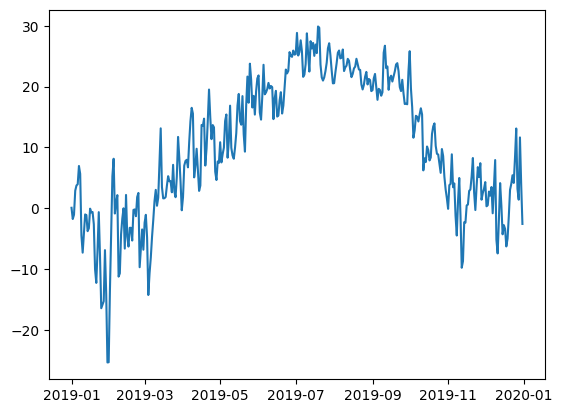

In [47]:
plt.plot(avg_weather2019["date_list"], avg_weather2019["avg_temp"]);

# Section 4: Merge all data together

## Merge all data together
1. Bike trips
2. Bike station geocode
3. Weather data

In [48]:
# Merge to obtain df2
df2 = pd.merge(left=merged_df, right=avg_weather2019,       
               how="left",
               left_on="start_time_dt",
               right_on="date_list")

In [49]:
# Check number of NA values in each column
df2.isna().sum()

tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               20412
birthyear                0
from_lat                42
from_lng                42
to_lat                 171
to_lng                 171
distance               203
start_time_dt            0
end_time_dt              0
date_list                0
avg_temp                 0
dtype: int64

In [50]:
# Drop rows containing missing values
df2.dropna(axis=0, how="any", inplace=True)

In [127]:
# Write df2 into folder for reload in the future
if "df2.csv" in os.listdir(dir_path):
    pass
else:
    df2.to_csv(dir_path + "df2.csv",
               index=False)